In [5]:
import numpy as np
import glob
import os
import logging
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\npy\1030\p00"
OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\img\1030"

In [3]:
def create_signal_images(target,count,out_path_abp,out_path_ppg):
    px = 256
    def ppg_img(sig,out_path_ppg,count):
        im_arr = np.zeros((px,px),dtype=np.uint8)
        rescaled = (255.0*sig).astype(np.uint8)
        #rescaled = np.array(j).astype(np.uint8)
        im_arr[:,:] = rescaled[:,None]
        im = Image.fromarray(im_arr.T)
        im.save(out_path_ppg.format(count))
        return 
    def abp_img(sig,out_path_abp,count):
        im_arr = np.zeros((px,px),dtype=np.uint8)
        abp_max = 255
        abp_min = 0
        rescaled = (255.0/(abp_max-abp_min)*(sig-abp_min)).astype(np.uint8)
        im_arr[:,:] = rescaled[:,None]
        im = Image.fromarray(im_arr.T)
        im.save(out_path_abp.format(count))
        return
    for i in range(0,len(target)-px,px):
        s = target[i:i+px,:]
        abp_img(s[:,0],out_path_abp,count)
        ppg_img(s[:,1],out_path_ppg,count)
        count+=1
    return count

In [4]:
def create_image_executor(dir1):
    DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\npy\1030\p00"
    OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\img\1030"
    os.makedirs(f"{OUTPUT_DIR}\\abp\p00\{dir1}",exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}\\ppg\p00\{dir1}",exist_ok=True)
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    out_path_abp = f"{OUTPUT_DIR}\\abp\p00\{dir1}\\"+"{:07d}.png"
    out_path_ppg = f"{OUTPUT_DIR}\\ppg\p00\{dir1}\\"+"{:07d}.png"
    for file in files:
        sig = np.load(os.path.join(DATA_DIR,file))
        nan_locs = np.where(np.isnan(sig))[0]
        count = 0
        for n in range(len(nan_locs)-1):
            target = sig[nan_locs[n]+1:nan_locs[n+1]]
            count = create_signal_images(target,count,out_path_abp,out_path_ppg)

In [58]:
def create_npy_executor(dir1):
    px = 256
    max= 200
    DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\npy\1030\p00"
    OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\sig_npy\1107_norm"
    os.makedirs(f"{OUTPUT_DIR}\\p00\{dir1}",exist_ok=True)
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    out_path = f"{OUTPUT_DIR}\\p00\{dir1}\\{dir1}_"+"{:06d}.npy"
    count = 0
    for file in files:
        sig = np.load(os.path.join(DATA_DIR,file))
        sig[:,0] = sig[:,0]/max
        nan_locs = np.where(np.isnan(sig))[0]
        for n in range(len(nan_locs)-1):
            target = sig[nan_locs[n]+1:nan_locs[n+1]]
            for i in range(0,len(target)-px,px):
                s = target[i:i+px,:]
                np.save(out_path.format(count),s.astype(np.float16))
                count+=1

In [59]:
import concurrent.futures
import time
from multiprocessing import Pool
dirs = glob.glob("p*",root_dir=DATA_DIR)
# futures =[]
# with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
# p = Pool(8) # プロセス数を4に設定
for i in tqdm(range(len(dirs))):
    patients_num = int(dirs[i][1:])
    # print(patients_num)
    # if patients_num < 4680:
    #     continue
    # create_image_executor(dirs[i])
    create_npy_executor(dirs[i])
        # futures.append(executor.submit(create_image_executor,dirs[i]))
    # concurrent.futures.wait(futures,timeout=None,return_when=concurrent.futures.ALL_COMPLETED)
    # executor.shutdown()
print("done")
    

  2%|▏         | 2/121 [01:12<1:11:49, 36.21s/it]


KeyboardInterrupt: 

# filename修正
p000000_000000.png

In [12]:
# OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\img\1030\abp\p00"
OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\sig_npy\1101_norm\p00"
dirs = glob.glob("p*",root_dir=OUTPUT_DIR)
for i in tqdm(range(len(dirs))):
    patients = dirs[i]
    files = glob.glob(patients+"\*",root_dir=OUTPUT_DIR)
    for f in files:
        #p123456/1234567.png
        n = f[-10:-4]
        # newname = f"{patients}_{n}.png"
        newname = f"{n}.npy"
        os.rename(os.path.join(OUTPUT_DIR,f),os.path.join(OUTPUT_DIR,patients,newname)) 
        

100%|██████████| 121/121 [06:22<00:00,  3.16s/it]


7:3に分割　patients単位

100%|██████████| 117/117 [00:08<00:00, 13.47it/s]


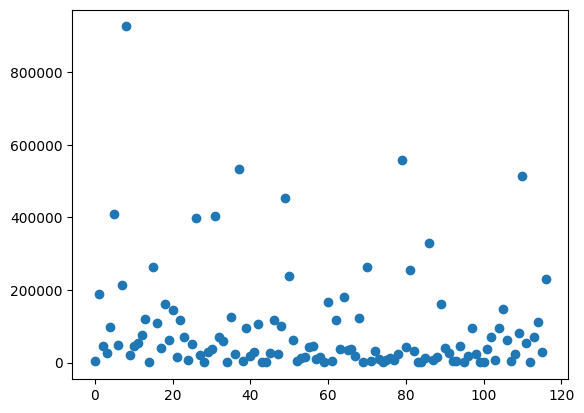

In [33]:
OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\sig_npy\1120\p00"
dirs = glob.glob("p*.npy",root_dir=OUTPUT_DIR)
nums = []
for i in tqdm(range(len(dirs))):
    npy = np.load(os.path.join(OUTPUT_DIR,dirs[i]))
    nums.append(npy.shape[0])
plt.scatter(np.arange(0,len(nums)),nums)

In [34]:
npy.dtype

dtype('float32')

In [35]:
sum = np.sum(nums)
print("sum",sum)
train_ratio = int(0.7 * sum)
count = 0
p_test = []
p_train = []
i = 0
while train_ratio > count:
    p_train.append(dirs[i])
    count += nums[i]
    i+= 1
    
for j in range(i,len(dirs)):
    p_test.append(dirs[j])

p_train = "\n".join(p_train)
p_test = "\n".join(p_test)

with open("../data/processed/list/train_p00_v4.txt", mode="w") as tr, open("../data/processed/list/test_p00_v4.txt", mode="w") as t:
    tr.writelines(p_train)
    t.writelines(p_test)




sum 10733171


flistを作成(参考：Palette\preprocess\mirflickr25k_preprocess.py)

In [32]:
DIR= "img/1030"
# DIR= "sig_npy/1101_norm"
with open("../data/processed/list/train_p00.txt", mode="r") as tr, open(f"../data/processed/{DIR}/train.flist",mode='w') as f:
    l = tr.readlines()
    for i in tqdm(range(len(l))):
        dir = l[i]
        # print(dir[:-1])
        files=glob.glob(f"{dir[:-1]}/*.png",root_dir=f"../data/processed/{DIR}/abp/p00")
        # files=glob.glob(f"{dir[:-1]}/*.npy",root_dir=f"../data/processed/{DIR}/p00")
        # print(len(files))
        for file in files:
            print(file[:-4],file=f)


100%|██████████| 82/82 [00:00<00:00, 27374.48it/s]


In [22]:
# DIR= "sig_npy/1101_norm"
DIR= "img/1030"
with open("../data/processed/list/test_p00.txt", mode="r") as tr, open(f"../data/processed/{DIR}/test.flist",mode='w') as f:
    l = tr.readlines()
    for i in tqdm(range(len(l))):
        dir = l[i]
        # print(dir[:-1])
        # files=glob.glob(f"{dir[:-1]}/*.npy",root_dir=f"../data/processed/{DIR}/p00")
        files=glob.glob(f"{dir[:-1]}/*.png",root_dir=f"../data/processed/{DIR}/abp/p00")
        # print(len(files))
        for file in files:
            print(file[:-4],file=f)

100%|██████████| 39/39 [00:01<00:00, 20.82it/s]


連結

In [63]:
def create_npy_executor_big(dir1):
    px = 256
    max= 200
    avg = 80
    dtype=np.float16
    DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\raw\BPDataset_norm\p00"
    OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\1121"
    os.makedirs(f"{OUTPUT_DIR}\\p00",exist_ok=True)
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    out_path = f"{OUTPUT_DIR}\\p00\\{dir1}.npy"
    s = []
    count = 0
    for file in files:
        sig = np.load(os.path.join(DATA_DIR,file))
        # print(sig.shape)
        sig[:,0] = (sig[:,0])/max
        nan_locs = np.where(np.isnan(sig[:,0]))[0]
        # print(len(nan_locs))
        if not len(nan_locs):
            # print("no nan")
            target = sig
            for i in range(0,len(target)-px,px):
                s.append(target[i:i+px,:].astype(dtype))
        else:
            for n in range(len(nan_locs)-1):
                target = sig[nan_locs[n]+1:nan_locs[n+1]]
                for i in range(0,len(target)-px,px):
                    s.append(target[i:i+px,:].astype(dtype))
                    # count+=1
        # print(count)
    if len(s):
        s = np.stack(s,dtype=dtype)
        print(s.shape)
        np.save(out_path,s)
    else:
        print("##### NO SIGNAL:", dir1)
        

In [64]:
import concurrent.futures
import time
from multiprocessing import Pool
import glob
DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\raw\BPDataset_norm\p00"
dirs = glob.glob("p*",root_dir=DATA_DIR)
# futures =[]
# with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
# p = Pool(8) # プロセス数を4に設定
for i in tqdm(range(len(dirs))):
    # patients_num = int(dirs[i][1:])
    # print(patients_num)
    # if patients_num < 4680:
    #     continue
    # create_image_executor(dirs[i])
    create_npy_executor_big(dirs[i])
        # futures.append(executor.submit(create_image_executor,dirs[i]))
    # concurrent.futures.wait(futures,timeout=None,return_when=concurrent.futures.ALL_COMPLETED)
    # executor.shutdown()
print("done")

  0%|          | 0/12 [00:00<?, ?it/s]

124694
(124694, 256, 2)


  8%|▊         | 1/12 [00:04<00:53,  4.83s/it]

108995
(108995, 256, 2)


 17%|█▋        | 2/12 [00:10<00:54,  5.40s/it]

87956
(87956, 256, 2)


 25%|██▌       | 3/12 [00:15<00:47,  5.24s/it]

119290
(119290, 256, 2)


 33%|███▎      | 4/12 [00:21<00:42,  5.35s/it]

127278
(127278, 256, 2)


 42%|████▏     | 5/12 [00:27<00:40,  5.73s/it]

124252
(124252, 256, 2)


 50%|█████     | 6/12 [00:34<00:36,  6.01s/it]

59898
(59898, 256, 2)


 58%|█████▊    | 7/12 [00:40<00:30,  6.01s/it]

94344
(94344, 256, 2)


 67%|██████▋   | 8/12 [00:46<00:24,  6.05s/it]

121720
(121720, 256, 2)


 75%|███████▌  | 9/12 [00:52<00:18,  6.03s/it]

115353
(115353, 256, 2)


 83%|████████▎ | 10/12 [00:58<00:12,  6.07s/it]

117123
(117123, 256, 2)


 92%|█████████▏| 11/12 [01:04<00:06,  6.01s/it]

95922
(95922, 256, 2)


100%|██████████| 12/12 [01:10<00:00,  5.86s/it]

done


nan確認

In [12]:
OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\sig_npy\1107_concat\p00"
files = glob.glob(".\*",root_dir=OUTPUT_DIR)
print(len(files))
for file in files:
    a = np.load(OUTPUT_DIR+"\\"+file)
    print(np.sum((np.isnan(a))),file)

121
0 .\p000160.npy
0 .\p000188.npy
0 .\p000333.npy
0 .\p000543.npy
0 .\p000618.npy
0 .\p000652.npy
0 .\p000735.npy
0 .\p000773.npy
0 .\p000801.npy
0 .\p000878.npy
0 .\p001004.npy
0 .\p001038.npy
0 .\p001049.npy
0 .\p001158.npy
0 .\p001190.npy
0 .\p001331.npy
0 .\p001501.npy
0 .\p001606.npy
0 .\p001791.npy
0 .\p001840.npy
0 .\p001855.npy
0 .\p001949.npy
0 .\p001978.npy
0 .\p002045.npy
0 .\p002063.npy
0 .\p002104.npy
0 .\p002343.npy
0 .\p002369.npy
0 .\p002458.npy
0 .\p002513.npy
0 .\p002577.npy
0 .\p002586.npy
0 .\p002636.npy
0 .\p002639.npy
0 .\p002858.npy
0 .\p002906.npy
0 .\p003039.npy
0 .\p003386.npy
0 .\p003617.npy
0 .\p003695.npy
0 .\p003744.npy
0 .\p003866.npy
0 .\p003949.npy
0 .\p004053.npy
0 .\p004113.npy
0 .\p004313.npy
0 .\p004324.npy
0 .\p004331.npy
0 .\p004405.npy
0 .\p004588.npy
0 .\p004679.npy
0 .\p004802.npy
0 .\p004804.npy
0 .\p004833.npy
0 .\p004837.npy
0 .\p004900.npy
0 .\p004904.npy
0 .\p004906.npy
0 .\p004958.npy
0 .\p004966.npy
0 .\p005071.npy
0 .\p005193.npy
0 .\

血圧の正規化

In [ ]:
def npy_fix_1120(dir1):
    DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\sig_npy\1107_concat\p00"
    OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\sig_npy\1120"
    # os.makedirs(f"{OUTPUT_DIR}\\p00\{dir1}",exist_ok=True)
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    out_path = f"{OUTPUT_DIR}\\p00\{dir1}.npy"
    s = []
    count = 0
    for file in files:
        sig = np.load(os.path.join(DATA_DIR,file))
        sig[:,0] = sig[:,0]- 0.5
        np.save(out_path,sig)
    else:
        print("##### NO SIGNAL:", dir1)

平均値確認

In [73]:
DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\sig_npy\1107_concat\p00"
files = glob.glob("*.npy",root_dir=DATA_DIR)
count = 0
sum_ = 0
for i in tqdm(range(len(files))):
    sig = np.load(os.path.join(DATA_DIR,files[i]))
    # print(sig.shape)
    if sig.shape[0] == 0:
        continue
    count += sig.shape[0]*sig.shape[1]
    sum_ += np.sum(sig[:,:,0],dtype=np.float64)
    
    # print(np.count_nonzero(np.isnan(sig[:,:,0])),np.sum(sig[:,:,0],dtype=np.float64))
mean = sum_/count
print(f"sum: {sum_}, mean: {mean}")

100%|██████████| 121/121 [00:06<00:00, 18.26it/s]

sum: 1087896944.2445848, mean: 0.39593121533751857


分散

In [76]:
count_v = 0
sum_v = 0
for i in tqdm(range(len(files))):
    sig = np.load(os.path.join(DATA_DIR,files[i]))
    # print(sig.shape)
    if sig.shape[0] == 0:
        continue
    count_v += sig.shape[0]*sig.shape[1]
    sum_v += np.sum((sig[:,:,0]-mean)**2,dtype=np.float64)
var = sum_v/count_v
std_ppg = np.sqrt(var)
print(f"sum: {sum_v}, var: {var}, std: {std}")

100%|██████████| 121/121 [00:24<00:00,  4.90it/s]

sum: 50001803.95393777, var: 0.018197748521389383, std: 0.13489903083932583


In [78]:
0.10694360087091538 /0.494153162946643,0.13489903083932583/0.39593121533751857


(0.21641792239719568, 0.3407132997188129)

ppg
- mean: 0.494153162946643
- std: 0.10694360087091538  

abp
- mean: 0.39593121533751857
- std: 0.13489903083932583



dtype確認

In [25]:
x = np.load(r"D:\minowa\BloodPressureEstimation\data\processed\npy\1030\p00\p000160\3531764_0003.npy")
print(x.dtype,x.shape,x[100:110,:])

float64 (1321391, 2) [[115.77582515   0.5022476 ]
 [114.40685424   0.50146437]
 [113.82015243   0.50076913]
 [114.99355606   0.50019788]
 [117.34036332   0.49977193]
 [119.88273786   0.49949597]
 [121.83841059   0.49935813]
 [123.01181422   0.49935813]
 [123.40294876   0.49938282]
 [123.20738149   0.49946932]]


In [44]:
x = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\sig_npy\1120\p00\p008281.npy")
print(np.max(np.abs((x[100:110,:]-x[100:110,:].astype(np.float16)).astype(np.float64)*200)))
print(np.mean(np.abs(((x[100:1000,:]-(x[100:1000,:]+0.4).astype(np.float16)).astype(np.float64)+0.4)*200)))
# print(x.dtype,x.shape,x[100:110,:],x[100:110,:].astype(np.float16))


0.04869699478149414
0.02124548401417455
